# Importação de dependencias


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import ast
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# importação api parceiro


In [ ]:
api_parceiro = "/content/drive/Shareddrives/M8-G3/Dados/api parceiro/dados_api_sale.csv"

In [ ]:
df_api = pd.read_csv(api_parceiro)

In [ ]:
df_api_reg_lin = df_api

In [ ]:
columns_to_drop = ['id', 'cnpj', 'idCategory', 'amount', 'category']
df_api_reg_lin = df_api_reg_lin.drop(columns=columns_to_drop, errors='ignore')

No dataframe que usaremos da API do parceiro, deixaremos apenas as colunas que iremos usar para a criação do modelo de regressão linear, no caso: 'saleDate' e 'value'.

In [ ]:
df_api_reg_lin

,saleDate,value
0,2023-10-06T00:00:10.117,495.0
1,2023-10-06T00:00:10.21,946.0
2,2023-10-06T00:00:10.21,906.0
3,2023-10-06T00:00:10.21,789.0
4,2023-10-06T00:00:10.21,240.0
...,...,...
34235,2023-12-05T00:00:09.807,213.0
34236,2023-12-05T00:00:09.807,557.0
34237,2023-12-05T00:00:09.807,250.0
34238,2023-12-05T00:00:09.807,849.0


Agora nós iremos usar a biblioteca SARIMAX criar o modelo de regressão linear e a biblioteca matplotlib para plotar os gráficos.

O primeiro gráfico é uma série temporal do valor dos produtos vendidos ao longo do ano de 2023. Em seguida temos o segundo gráfico referente à previsões do modelo SARIMAX para o período seguinte comparado ao teste do modelo.

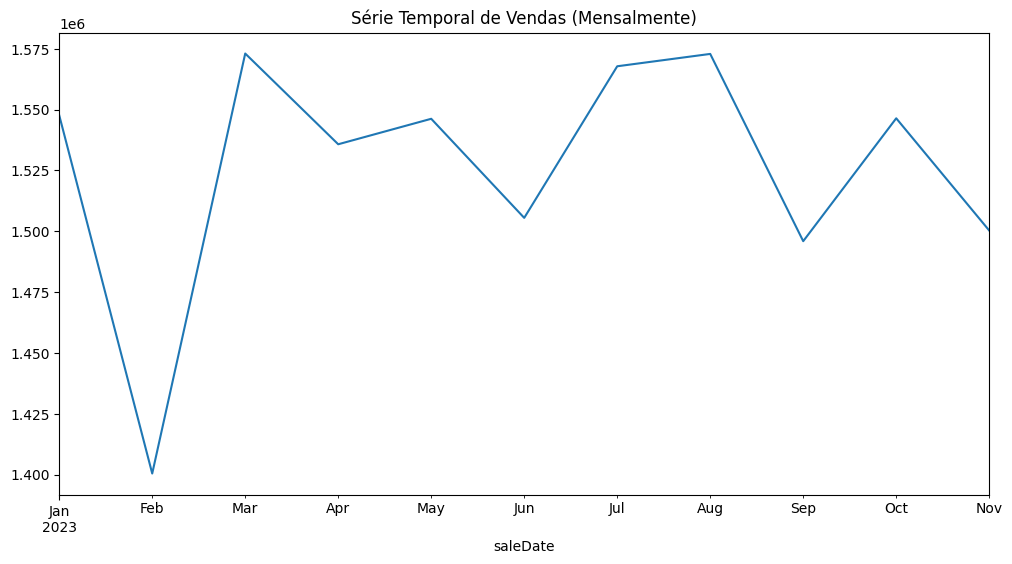

ADF Statistic: -4.285922700335052
p-value: 0.0004698182939428058
Critical Values: {'1%': -4.331573, '5%': -3.23295, '10%': -2.7487}


In [ ]:
df_api_reg_lin['saleDate'] = pd.to_datetime(df_api_reg_lin['saleDate'])
df_api_reg_lin.set_index('saleDate', inplace=True)

df_api_reg_lin = df_api_reg_lin[~((df_api_reg_lin.index.month == 12) & (df_api_reg_lin.index.year == 2023))]
df_api_reg_lin = df_api_reg_lin.groupby(df_api_reg_lin.index).filter(lambda x: len(x) > 1)

df_monthly = df_api_reg_lin.resample('M').sum()

df_monthly['value'].plot(figsize=(12, 6))
plt.title('Série Temporal de Vendas (Mensalmente)')
plt.show()

result = adfuller(df_monthly['value'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] > 0.05:
    df_monthly_diff = df_monthly.diff().dropna()
    df_monthly_diff['value'].plot(figsize=(12, 6))
    plt.title('Série Temporal Diferenciada (Mensalmente)')
    plt.show()

train_size = int(len(df_monthly) * 0.8)
train, test = df_monthly.iloc[:train_size], df_monthly.iloc[train_size:]

order = (1, 1, 1)
seasonal_order = (1, 1, 1, 11)

model = SARIMAX(train['value'], order=order, seasonal_order=seasonal_order)
result = model.fit(disp=False)

start = len(train)
end = start + len(test) - 1
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels')

mse = mean_squared_error(test['value'], predictions)
print('Mean Squared Error:', mse)

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['value'], label='Treino')
plt.plot(test.index, test['value'], label='Teste')
plt.plot(test.index, predictions, label='Previsões')
plt.legend()
plt.title('Previsões do Modelo SARIMAX (Mensalmente)')
plt.xlabel('Data')
plt.ylabel('Valor')

plt.show()